# Preparing data

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import sys
from pandas import DataFrame
np.set_printoptions(threshold=sys.maxsize)
height = 256
width = 256
batch_size = 64
datagen = ImageDataGenerator(validation_split=0.1)
train_generator = datagen.flow_from_directory(
        'BOSSbase_1.01-256_wow_1.6',
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        color_mode='grayscale',
        target_size = (height, width))

validation_generator = datagen.flow_from_directory(
        'BOSSbase_1.01-256_wow_1.6',
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        color_mode='grayscale',
        target_size = (height, width))

Using TensorFlow backend.


Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# GNCNN Model

In [2]:
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, AveragePooling2D, Activation, Lambda
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.utils.generic_utils import get_custom_objects
from livelossplot import PlotLossesKeras

In [3]:
num_classes = 2

In [4]:
def gaussian_activation(x):
    alpha = 1
    sigma = 0.1
    return alpha*K.exp(-(x*x)/(sigma*sigma))

get_custom_objects().update({'gaussian_activation': Activation(gaussian_activation)})

In [5]:
import numpy as np
kernel = np.array((
    [-1,  2,  -2,  2, -1],
    [ 2, -6,   8, -6,  2],
    [-2,  8, -12,  8, -2],
    [ 2, -6,   8, -6,  2],
    [-1,  2,  -2,  2, -1]), dtype="float")
kernel = np.divide(kernel, 12)
im_proc_layer = Conv2D(1, 5, activation=None, padding='valid', input_shape=(256, 256, 1), use_bias=False)

In [6]:
l2_lambda = 0.001; #use 0.0001 as a L2-regularisation factor
import tensorflow as tf
model = Sequential()
model.add(im_proc_layer)
model.add(Lambda(lambda x: tf.div(tf.clip_by_value(x, 0, 255), 255)))
# model.add(Lambda(lambda x: tf.cast(tf.multiply(x, 255), tf.uint8)))
# model.add(Lambda(lambda x: tf.divide(x, 255)))
model.add(Lambda(lambda x: tf.subtract(x, tf.reduce_mean(x, keepdims=True))))
# model.add(Lambda(lambda x: tf.math.reduce_std(x, keepdims=True)))
# model.add(Lambda(lambda x: tf.sqrt(tf.reduce_mean(tf.square(x - tf.reduce_mean(x, keepdims=True)), keepdims=True))))
model.add(Lambda(lambda x: tf.divide(x, tf.add(tf.sqrt(tf.reduce_mean(tf.square(x - tf.reduce_mean(x, keepdims=True)), keepdims=True)), 1e-6))))
model.add(Conv2D(16, 5, activation='gaussian_activation',W_regularizer=l2(l2_lambda), init='he_normal', padding='same'))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(16, 3, activation='gaussian_activation',W_regularizer=l2(l2_lambda), init='he_normal', padding='valid'))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(16, 3, activation='gaussian_activation',W_regularizer=l2(l2_lambda), init='he_normal', padding='valid'))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(16, 3, activation='gaussian_activation',W_regularizer=l2(l2_lambda), init='he_normal', padding='valid'))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(16, 5, activation='gaussian_activation',W_regularizer=l2(l2_lambda), init='he_normal', padding='valid'))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 252, 252, 1)       25        
_________________________________________________________________
lambda_1 (Lambda)            (None, 252, 252, 1)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 252, 252, 1)       0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 252, 252, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 16)      416       
_________________________________________________________________
average_pooling2d_1 (Average (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 123, 123, 16)      2320      
__________

In [8]:
import cv2
# from keras import backend as K
# from keras.layers import Layer

# class MyLayer(Layer):

#     def __init__(self, output_dim, **kwargs):
#         self.output_dim = output_dim
#         super(MyLayer, self).__init__(**kwargs)

#     def build(self, input_shape):
#         # Create a trainable weight variable for this layer.
#         self.kernel = self.add_weight(name='kernel', 
#                                       shape=(input_shape[1], self.output_dim),
#                                       initializer=None,
#                                       trainable=False)
#         self.set_weights(np.array([kernel.reshape(5,5,1,1)]))
#         super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

#     def call(self, x):
#         return (rescale_intensity(K.dot(x, self.kernel)) * 255).astype("uint8")

#     def compute_output_shape(self, input_shape):
#         return (input_shape[0], self.output_dim)

# my_im_proc_layer = MyLayer(1, 5, activation=None, padding='valid', input_shape=(256, 256, 1), bias=False)
# import cv2
# from keras.models import Model
# from keras.layers import Input
# from skimage.util.dtype import dtype_range
from skimage.exposure import rescale_intensity
# inp = Input(shape=(256,256,1))
im_proc_layer.set_weights(np.array([kernel.reshape(5,5,1,1)]))
im_proc_layer.trainable = False
orig_image = cv2.imread('test/cover/1.pgm', cv2.IMREAD_GRAYSCALE)
# print(orig_image)
# print(Model(input=inp, output=im_proc_layer(inp)).predict(orig_image.reshape(1,256, 256,1)).shape)
# output = rescale_intensity(Model(input=inp, output=im_proc_layer(inp)).predict(orig_image.reshape(1,256, 256,1)).reshape(252,252), in_range=(0, 255))
# print(output)
# output = (output * 255).astype("uint8")
# print(output)
output = model.predict(orig_image.reshape(1,256,256,1))
# output = output.reshape(252,252)
def convolve(image, kernel):
    i_width, i_height = image.shape[0], image.shape[1]
    k_width, k_height = kernel.shape[0], kernel.shape[1]
    pad = k_width // 2
    output = np.zeros((i_width - 2*pad, i_height - 2*pad), dtype="float32")

    for y in range(pad, i_height - pad):
        for x in range(pad, i_width - pad):
            weighted_pixel_sum = 0
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
            for ky in range(0, k_height):
                for kx in range(0, k_width):
                    weighted_pixel_sum += roi[ky, kx] * kernel[ky, kx]
            output[y - pad, x - pad] = weighted_pixel_sum
    print(output.dtype.type)
    output = rescale_intensity(output, in_range=(0, 255))
    output = (output * 255).astype("uint8")
 
    # return the output image
    return output

# kernel = np.array((
#     [-1,  2,  -2,  2, -1],
#     [ 2, -6,   8, -6,  2],
#     [-2,  8, -12,  8, -2],
#     [ 2, -6,   8, -6,  2],
#     [-1,  2,  -2,  2, -1]), dtype="float")
# kernel = np.divide(kernel, 12)
# output = convolve(orig_image, kernel)
print(output)
# DataFrame(output.reshape(252, 252)).to_csv('1_NN.csv')
# # print(orig_image)
# cv2.imwrite('test/cover/1.ppm', np.einsum('kij->ijk', np.array([output, output, output])))

[[0.6014133  0.39858666]]


In [9]:
sgd = keras.optimizers.SGD(lr=0.005, momentum=0.0, decay=0.0000005, nesterov=False)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(adam, 'categorical_crossentropy', metrics=['categorical_accuracy'])

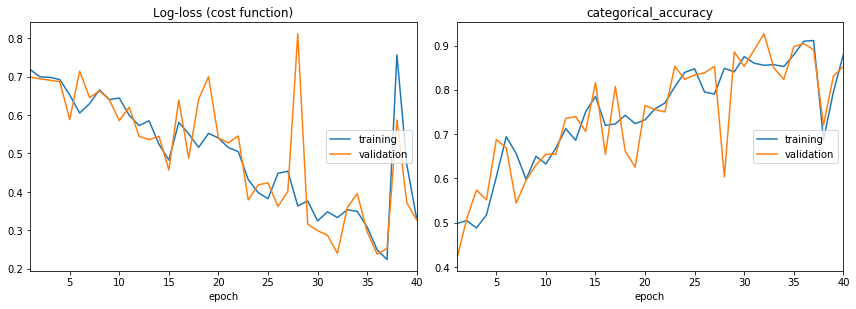

In [10]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=40,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=[PlotLossesKeras()])